In [2]:
import glob
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import torchvision
import torchvision.transforms as transforms
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def train_directory():
    pwd = os.getcwd()
    
    os.mkdir(pwd+'/training')
    os.mkdir(pwd+'/training/LUAD_TRAIN')
    os.mkdir(pwd+'/training/LUSC_TRAIN')
    os.mkdir(pwd+'/training/MESO_TRAIN')

    
    train_dir = '/kaggle/input/histopathology-dataset/train/'
    cancers = ["LUAD","LUSC","MESO"]
    luad_train_dir = '/kaggle/working/training/LUAD_TRAIN/'
    lusc_train_dir = '/kaggle/working/training/LUSC_TRAIN/'
    meso_train_dir = '/kaggle/working/training/MESO_TRAIN/'
    cat_train_dir = [luad_train_dir,lusc_train_dir,meso_train_dir]

    for i in range(3):
        for f in glob.iglob(train_dir+cancers[i]+"/*"):
            for subf in glob.iglob(f+'/*'):
                shutil.copy(subf,cat_train_dir[i])
    
    labels = ["LUAD","LUSC","MESO"]
    dir_label_df = pd.DataFrame(columns = ["directory","label"])
    for i in range(3):
        filepaths_i = glob.glob(cat_train_dir[i]+"/*")
        series_i = pd.Series(filepaths_i)
        df_i = pd.DataFrame(series_i,columns = ["directory"])
        df_i["label"] = labels[i]
        dir_label_df = pd.concat([dir_label_df,df_i],axis=0)
    
    return dir_label_df.reset_index(drop=True)

In [4]:
def test_directory():
    
    pwd = os.getcwd()
    
    os.mkdir(pwd+'/testing')
    os.mkdir(pwd+'/testing/LUAD_TEST')
    os.mkdir(pwd+'/testing/LUSC_TEST')
    os.mkdir(pwd+'/testing/MESO_TEST')

    test_dir = '/kaggle/input/histopathology-dataset/dev/'
    cancers = ["LUAD","LUSC","MESO"]
    luad_test_dir = '/kaggle/working/testing/LUAD_TEST/'
    lusc_test_dir = '/kaggle/working/testing/LUSC_TEST/'
    meso_test_dir = '/kaggle/working/testing/MESO_TEST/'
    cat_test_dir = [luad_test_dir,lusc_test_dir,meso_test_dir]


    for i in range(3):
        for f in glob.iglob(test_dir+cancers[i]+"/*"):
            for subf in glob.iglob(f+'/*'):
                shutil.copy(subf,cat_test_dir[i])


    labels = ["LUAD","LUSC","MESO"]
    test_label_df = pd.DataFrame(columns = ["directory","label"])
    for i in range(3):
        filepaths_i = glob.glob(cat_test_dir[i]+"/*")
        series_i = pd.Series(filepaths_i)
        df_i = pd.DataFrame(series_i,columns = ["directory"])
        df_i["label"] = labels[i]
        test_label_df = pd.concat([test_label_df,df_i],axis=0)


    test_label_df = test_label_df.reset_index(drop=True)
    return test_label_df

In [5]:
dir_label_df = train_directory()
test_label_df = test_directory()

In [6]:
dir_label_df

,directory,label
0,/kaggle/working/training/LUAD_TRAIN/TCGA-49-44...,LUAD
1,/kaggle/working/training/LUAD_TRAIN/TCGA-49-44...,LUAD
2,/kaggle/working/training/LUAD_TRAIN/TCGA-44-39...,LUAD
3,/kaggle/working/training/LUAD_TRAIN/TCGA-49-44...,LUAD
4,/kaggle/working/training/LUAD_TRAIN/TCGA-05-44...,LUAD
...,...,...
22399,/kaggle/working/training/MESO_TRAIN/TCGA-3H-AB...,MESO
22400,/kaggle/working/training/MESO_TRAIN/TCGA-3H-AB...,MESO
22401,/kaggle/working/training/MESO_TRAIN/TCGA-3H-AB...,MESO
22402,/kaggle/working/training/MESO_TRAIN/TCGA-3H-AB...,MESO


In [7]:
print(dir_label_df['label'].value_counts())

LUSC    16443
LUAD     5558
MESO      403
Name: label, dtype: int64


In [8]:
train,test = train_test_split(dir_label_df, test_size=0.2, random_state=42)

print(f"train set shape: {train.shape}")
print(f"test set shape: {test.shape}")

train set shape: (17923, 2)
test set shape: (4481, 2)


In [9]:
transform_train = transforms.Compose(
    [transforms.Resize((128,128)),
     transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()],0.5),
     transforms.ToTensor()])

In [10]:
def data_augmentation(train):
    
    aug_label_df = pd.DataFrame(columns = ["directory","label"])
    
    for i in range(len(train)):
        row = train.iloc[i]
        row_directory = row['directory']
        row_label = row['label']
        
        if row_label == "LUAD":
            
            for j in range(2):
                img = load_img(row_directory)
                trans_img = transform_train(img)
                new_dir = row_directory[:-4] + str(j) + '.jpg'
                save_img(new_dir,img_to_array(trans_img),data_format='channels_first')

                series_i = pd.Series(new_dir)
                df_i = pd.DataFrame(series_i,columns = ["directory"])
                df_i["label"] = "LUAD"
                aug_label_df = pd.concat([aug_label_df,df_i],axis=0)
                
        if row_label == "MESO":
            
            for z in range(25):
                
                img = load_img(row_directory)
                trans_img = transform_train(img)
                new_dir = row_directory[:-4] + str(z) + '.jpg'
                save_img(new_dir,img_to_array(trans_img),data_format='channels_first')

                series_i = pd.Series(new_dir)
                df_i = pd.DataFrame(series_i,columns = ["directory"])
                df_i["label"] = "MESO"
                aug_label_df = pd.concat([aug_label_df,df_i],axis=0)
                
    train = pd.concat([aug_label_df,train],axis=0)
        
    return train

In [11]:
train = data_augmentation(train)

In [12]:
print(train['label'].value_counts())

LUAD    13296
LUSC    13173
MESO     8268
Name: label, dtype: int64


In [ ]:
'''! mkdir testing
%cd testing
! mkdir LUAD_TEST
! mkdir LUSC_TEST
! mkdir MESO_TEST

test_dir = '../kaggle/input/histopathology-dataset/dev/'
cancers = ["LUAD","LUSC","MESO"]
luad_test_dir = '../kaggle/working/testing/LUAD_TEST/'
lusc_test_dir = '../kaggle/working/testing/LUSC_TEST/'
meso_test_dir = '../kaggle/working/testing/MESO_TEST/'
cat_test_dir = [luad_test_dir,lusc_test_dir,meso_test_dir]

%cd /kaggle

for i in range(3):
    for f in glob.iglob(test_dir+cancers[i]+"/*"):
        for subf in glob.iglob(f+'/*'):
            shutil.copy(subf,cat_test_dir[i])
            
            
labels = ["LUAD","LUSC","MESO"]
test_label_df = pd.DataFrame(columns = ["directory","label"])
for i in range(3):
    filepaths_i = glob.glob(cat_test_dir[i]+"/*")
    series_i = pd.Series(filepaths_i)
    df_i = pd.DataFrame(series_i,columns = ["directory"])
    df_i["label"] = labels[i]
    test_label_df = pd.concat([test_label_df,df_i],axis=0)
    
    
test_label_df = test_label_df.reset_index(drop=True)
test_label_df.head(),test_label_df.tail()'''

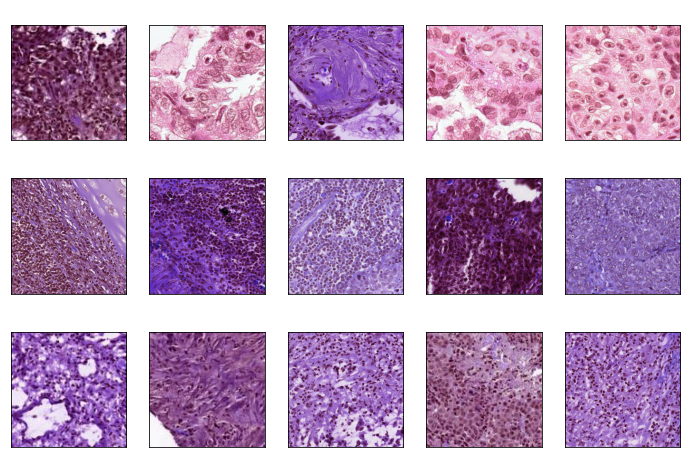

In [19]:
plt.figure(figsize=(12,8))
labels = ["LUAD","LUSC","MESO"]
pos = 1
for i in range(3):
    for j in range(5):
        labels_i = labels[i]
        index_i = dir_label_df[dir_label_df["label"] == labels_i].index
        random = np.random.randint(index_i[0],index_i[-1])
        plt.subplot(3,5,pos)
        pos+=1
        plt.imshow(cv2.imread(dir_label_df.loc[random,"directory"]))
        plt.title(dir_label_df.loc[random, "label"], size = 15, color = "white") 
        plt.xticks([])
        plt.yticks([])

plt.show()

In [ ]:
'''from PIL import Image
import cv2 as cv
import numpy as np
dir_img_rgb = dir_label_df.iloc[83]['directory']
img_rbg = cv.imread(dir_img_rgb)
plt.imshow(img_rbg)
img_hsv = cv.cvtColor(img_rbg,cv.COLOR_BGR2HSV)

lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

lower_red = np.array([150,135,100])
upper_red = np.array([170,255,255])

lower_notwhite = np.array([20,0,0])
upper_notwhite = np.array([102,255,255])
# Threshold the HSV image to get only blue colors
mask = cv.inRange(img_hsv, lower_red, upper_red)
# Bitwise-AND mask and original image
res = cv.bitwise_and(img_rbg,img_rbg, mask= mask)

plt.imshow(res)

lower_red = np.array([150,135,0])
upper_red = np.array([190,255,200])

plt.figure(figsize=(12,8))
pos = 1
for i in range(3):
    for j in range(5):
        labels_i = labels[i]
        index_i = dir_label_df[dir_label_df["label"] == labels_i].index
        random = np.random.randint(index_i[0],index_i[-1])
        plt.subplot(3,5,pos)
        pos+=1
        img_rbg = cv2.imread(dir_label_df.loc[random,"directory"])
        img_hsv = cv.cvtColor(img_rbg,cv.COLOR_BGR2HSV)
        mask = cv.inRange(img_hsv, lower_red, upper_red)
        res = cv.bitwise_and(img_rbg,img_rbg, mask= mask)
        plt.imshow(res)
        plt.title(dir_label_df.loc[random, "label"], size = 15, color = "white") 
        plt.xticks([])
        plt.yticks([])

plt.show()
'''

In [ ]:
train

In [13]:


train_datagen = ImageDataGenerator(rescale = 1./224.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/224.)

train_gen = train_datagen.flow_from_dataframe(dataframe = train,
                                              x_col = 'directory', y_col ='label',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'categorical', shuffle = True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'directory', y_col ='label',
                                             class_mode = 'categorical',
                                            batch_size = 16, shuffle = False)

validation_datagen = ImageDataGenerator(rescale = 1/224.)

validation_gen = validation_datagen.flow_from_dataframe(test_label_df,
                                            target_size = (224,224), x_col = 'directory', y_col ='label',
                                             class_mode = 'categorical',
                                            batch_size = 16, shuffle = False)

Found 34737 validated image filenames belonging to 3 classes.
Found 4481 validated image filenames belonging to 3 classes.
Found 8201 validated image filenames belonging to 3 classes.


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


def report_matrix(generator,model):
    test_steps_per_epoch = np.math.ceil(generator.samples / generator.batch_size)
    predictions = model.predict(generator,test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys()) 
    
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)
    
    conf_mat = confusion_matrix(true_classes, predicted_classes)
    print(conf_mat)
    
def model_metrics(generator,model):
    test_steps_per_epoch = np.math.ceil(generator.samples / generator.batch_size)
    predictions = model.predict(generator,test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    accuracy = accuracy_score(predicted_classes,true_classes)
    precision = precision_score(predicted_classes,true_classes,average='weighted')
    recall = recall_score(predicted_classes,true_classes,average='weighted')
    f1 = f1_score(predicted_classes,true_classes,average='weighted')
    #roc_auc = roc_auc_score(predictions,true_classes,multi_class='ovo',average='weighted')
    
    print("Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}".format(round(accuracy,4),
                                                                   round(precision,4),
                                                                   round(recall,4),
                                                                   round(f1,4)))

In [13]:
from tensorflow import keras
base_model = keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False,
)

2021-12-16 07:20:14.369580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:20:14.371138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:20:14.372221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:20:14.373733: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [14]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(128, 128, 3))

In [15]:
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

x = keras.layers.Dense(256)(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [16]:
callbacks = [EarlyStopping(monitor='val_loss',patience=2)]

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.fit(train_gen, validation_data = test_gen,
                    use_multiprocessing=True,
                    workers=6,
                    epochs = 15,
                    callbacks = callbacks,verbose=1)

2021-12-16 07:20:36.987004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-12-16 07:20:45.638651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1086/1086 [==============================] - 481s 431ms/step - loss: 0.6454 - accuracy: 0.7782 - val_loss: 0.4408 - val_accuracy: 0.8257
Epoch 2/15
1086/1086 [==============================] - 486s 444ms/step - loss: 0.4593 - accuracy: 0.8151 - val_loss: 0.4001 - val_accuracy: 0.8416
Epoch 3/15
1086/1086 [==============================] - 471s 432ms/step - loss: 0.4424 - accuracy: 0.8250 - val_loss: 0.4724 - val_accuracy: 0.8036
Epoch 4/15
1086/1086 [==============================] - 466s 427ms/step - loss: 0.4350 - accuracy: 0.8258 - val_loss: 0.3924 - val_accuracy: 0.8445
Epoch 5/15
1086/1086 [==============================] - 455s 416ms/step - loss: 0.4282 - accuracy: 0.8287 - val_loss: 0.4163 - val_accuracy: 0.8320
Epoch 6/15
1086/1086 [==============================] - 446s 409ms/step - loss: 0.4224 - accuracy: 0.8298 - val_loss: 0.4221 - val_accuracy: 0.8427


In [17]:
model.save("InceptionV3_6epoch.h5")

In [21]:
report_matrix(test_gen,model)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

        LUAD       0.85      0.49      0.62      1126
        LUSC       0.84      0.97      0.90      3270
        MESO       0.80      0.53      0.64        85

    accuracy                           0.84      4481
   macro avg       0.83      0.66      0.72      4481
weighted avg       0.84      0.84      0.83      4481

[[ 547  574    5]
 [  80 3184    6]
 [  13   27   45]]


In [22]:
report_matrix(validation_gen,model)

              precision    recall  f1-score   support

        LUAD       0.82      0.11      0.19      3214
        LUSC       0.57      0.98      0.72      4492
        MESO       0.00      0.00      0.00       495

    accuracy                           0.58      8201
   macro avg       0.46      0.36      0.30      8201
weighted avg       0.63      0.58      0.47      8201

[[ 352 2857    5]
 [  72 4403   17]
 [   5  490    0]]


In [14]:
from tensorflow import keras
base_model_resnet = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)
# Freeze the base_model
base_model_resnet.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

2021-12-16 09:48:45.137419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


94683136/94668760 [==============================] - 2s 0us/step


2021-12-16 09:48:45.138566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 09:48:45.139219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 09:48:45.140053: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-16 09:48:45.141376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [15]:
x = base_model_resnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

x = keras.layers.Dense(256)(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(3, activation="sigmoid")(x)
model_resnet = keras.Model(inputs, outputs)

model_resnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [16]:
callbacks = [EarlyStopping(monitor='val_loss',patience=4)]

model_resnet.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model_resnet.fit(train_gen, validation_data = test_gen,
                    use_multiprocessing=True,
                    workers=6,
                    epochs = 15,
                    callbacks = callbacks,verbose=1)

2021-12-16 09:48:54.256976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-12-16 09:49:01.557728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1086/1086 [==============================] - 476s 427ms/step - loss: 0.4794 - accuracy: 0.8272 - val_loss: 0.5125 - val_accuracy: 0.8237
Epoch 2/15
1086/1086 [==============================] - 444s 406ms/step - loss: 0.3730 - accuracy: 0.8549 - val_loss: 0.4776 - val_accuracy: 0.8286
Epoch 3/15
1086/1086 [==============================] - 450s 412ms/step - loss: 0.3607 - accuracy: 0.8592 - val_loss: 0.3388 - val_accuracy: 0.8732
Epoch 4/15
1086/1086 [==============================] - 447s 409ms/step - loss: 0.3554 - accuracy: 0.8631 - val_loss: 0.5579 - val_accuracy: 0.8226
Epoch 5/15
1086/1086 [==============================] - 454s 416ms/step - loss: 0.3444 - accuracy: 0.8659 - val_loss: 0.3274 - val_accuracy: 0.8741
Epoch 6/15
1086/1086 [==============================] - 452s 413ms/step - loss: 0.3464 - accuracy: 0.8663 - val_loss: 0.3256 - val_accuracy: 0.8784
Epoch 7/15
1086/1086 [==============================] - 446s 408ms/step - loss: 0.3350 - accuracy: 0.8695 - val_loss: 0.341

Process Keras_worker_ForkPoolWorker-182:
Process Keras_worker_ForkPoolWorker-181:
Process Keras_worker_ForkPoolWorker-184:
Process Keras_worker_ForkPoolWorker-183:
Process Keras_worker_ForkPoolWorker-186:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-185:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

In [17]:
model_resnet.save("Resnet_15epoch.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [45]:
model_metrics(test_gen,model_resnet)

Accuracy: 0.8469
Precision: 0.9292
Recall: 0.8469
F1: 0.8697


In [46]:

model_metrics(validation_gen,model_resnet)

Accuracy: 0.5748
Precision: 0.9662
Recall: 0.5748
F1: 0.701


In [19]:
report_matrix(test_gen,model_resnet)

              precision    recall  f1-score   support

        LUAD       0.97      0.42      0.59      1126
        LUSC       0.83      1.00      0.91      3270
        MESO       0.89      0.78      0.83        85

    accuracy                           0.85      4481
   macro avg       0.90      0.73      0.77      4481
weighted avg       0.87      0.85      0.82      4481

[[ 474  647    5]
 [  12 3255    3]
 [   2   17   66]]


In [20]:
report_matrix(test_gen,model_resnet)
report_matrix(validation_gen,model_resnet)

              precision    recall  f1-score   support

        LUAD       0.93      0.07      0.14      3214
        LUSC       0.56      1.00      0.72      4492
        MESO       0.25      0.00      0.00       495

    accuracy                           0.57      8201
   macro avg       0.58      0.36      0.29      8201
weighted avg       0.69      0.57      0.45      8201

[[ 240 2972    2]
 [  18 4473    1]
 [   1  493    1]]


In [47]:
base_model_densenet = keras.applications.DenseNet121(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)
# Freeze the base_model
base_model_densenet.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

29097984/29084464 [==============================] - 1s 0us/step


In [48]:
x = base_model_densenet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

x = keras.layers.Dense(256)(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(3, activation="sigmoid")(x)
model_densenet = keras.Model(inputs, outputs)

model_densenet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

In [49]:
callbacks = [EarlyStopping(monitor='val_loss',patience=4)]

model_densenet.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model_densenet.fit(train_gen, validation_data = test_gen,
                    use_multiprocessing=True,
                    workers=6,
                    epochs = 15,
                    callbacks = callbacks,verbose=1)

Epoch 1/15
1086/1086 [==============================] - 474s 428ms/step - loss: 0.4499 - accuracy: 0.8274 - val_loss: 0.4034 - val_accuracy: 0.8496
Epoch 2/15
1086/1086 [==============================] - 449s 411ms/step - loss: 0.3824 - accuracy: 0.8497 - val_loss: 0.4061 - val_accuracy: 0.8465
Epoch 3/15
1086/1086 [==============================] - 439s 401ms/step - loss: 0.3708 - accuracy: 0.8553 - val_loss: 0.3462 - val_accuracy: 0.8708
Epoch 4/15
1086/1086 [==============================] - 449s 410ms/step - loss: 0.3585 - accuracy: 0.8586 - val_loss: 0.3962 - val_accuracy: 0.8661
Epoch 5/15
1086/1086 [==============================] - 441s 403ms/step - loss: 0.3530 - accuracy: 0.8627 - val_loss: 0.5331 - val_accuracy: 0.8299
Epoch 6/15
1086/1086 [==============================] - 454s 415ms/step - loss: 0.3489 - accuracy: 0.8643 - val_loss: 0.5677 - val_accuracy: 0.8371
Epoch 7/15
1086/1086 [==============================] - 453s 414ms/step - loss: 0.3452 - accuracy: 0.8646 - val_

Process Keras_worker_ForkPoolWorker-402:
Process Keras_worker_ForkPoolWorker-401:
Process Keras_worker_ForkPoolWorker-397:
Process Keras_worker_ForkPoolWorker-398:
Process Keras_worker_ForkPoolWorker-399:
Process Keras_worker_ForkPoolWorker-400:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/con

In [50]:
model_densenet.save("DenseNet_15epoch.h5")

In [53]:
model_metrics(test_gen,model_densenet)

Accuracy: 0.8757
Precision: 0.9152
Recall: 0.8757
F1: 0.8861


In [54]:
model_metrics(validation_gen,model_densenet)


Accuracy: 0.5808
Precision: 0.9424
Recall: 0.5808
F1: 0.6944


In [55]:
report_matrix(test_gen,model_densenet)

              precision    recall  f1-score   support

        LUAD       0.92      0.57      0.70      1126
        LUSC       0.87      0.98      0.92      3270
        MESO       0.92      0.78      0.84        85

    accuracy                           0.88      4481
   macro avg       0.90      0.78      0.82      4481
weighted avg       0.88      0.88      0.87      4481

[[ 644  476    6]
 [  56 3214    0]
 [   2   17   66]]


In [56]:
report_matrix(validation_gen,model_densenet)

              precision    recall  f1-score   support

        LUAD       0.83      0.10      0.18      3214
        LUSC       0.57      0.99      0.72      4492
        MESO       0.00      0.00      0.00       495

    accuracy                           0.58      8201
   macro avg       0.46      0.36      0.30      8201
weighted avg       0.64      0.58      0.47      8201

[[ 334 2879    1]
 [  63 4429    0]
 [   7  488    0]]


In [60]:
! ls /kaggle/input/inceptionv3yhr/InceptionV3_6epoch.h5

InceptionV3_6epoch.h5


In [62]:
inceptionv3 = keras.models.load_model('/kaggle/input/inceptionv3yhr/InceptionV3_6epoch.h5')

In [66]:
model_metrics(test_gen,inceptionv3)
model_metrics(validation_gen,inceptionv3)
report_matrix(test_gen,inceptionv3)
report_matrix(validation_gen,inceptionv3)

Accuracy: 0.846
Precision: 0.8996
Recall: 0.846
F1: 0.8615
Accuracy: 0.5798
Precision: 0.932
Recall: 0.5798
F1: 0.6899
              precision    recall  f1-score   support

        LUAD       0.86      0.49      0.62      1126
        LUSC       0.84      0.97      0.90      3270
        MESO       0.81      0.66      0.73        85

    accuracy                           0.85      4481
   macro avg       0.84      0.71      0.75      4481
weighted avg       0.85      0.85      0.83      4481

[[ 551  569    6]
 [  79 3184    7]
 [  11   18   56]]
              precision    recall  f1-score   support

        LUAD       0.82      0.11      0.19      3214
        LUSC       0.57      0.98      0.72      4492
        MESO       0.00      0.00      0.00       495

    accuracy                           0.58      8201
   macro avg       0.46      0.36      0.30      8201
weighted avg       0.63      0.58      0.47      8201

[[ 352 2857    5]
 [  72 4403   17]
 [   5  490    0]]
